### SI 670: Final Project EDA

#### Step 0. Import necessary libraries/packages and dataset

In [1]:
# Import libraries/packages
# Standard Python viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NFL library
import nfl_data_py as nfl

In [2]:
# Import NFL dataset
df = nfl.import_pbp_data([2024])
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Print dimensions of the dataframe
print(df.shape)

2024 done.
Downcasting floats.
(49492, 397)


#### Step 1. Exploratory Data Analysis

Dataset contains almost 400 columns. Need to reduce to columns that are most meaningful for our prediction problem

In [34]:
# Get datatypes for each column
print(df.dtypes.sort_index())

aborted_play                            float32
air_epa                                 float32
air_wpa                                 float32
air_yards                               float32
assist_tackle                           float32
assist_tackle_1_player_id                object
assist_tackle_1_player_name              object
assist_tackle_1_team                     object
assist_tackle_2_player_id                object
assist_tackle_2_player_name              object
assist_tackle_2_team                     object
assist_tackle_3_player_id                object
assist_tackle_3_player_name              object
assist_tackle_3_team                     object
assist_tackle_4_player_id                object
assist_tackle_4_player_name              object
assist_tackle_4_team                     object
away_coach                               object
away_score                                int32
away_team                                object
away_timeouts_remaining                 

A lot of columns to consider, but first need to examine "play_type" to only consider what might be relevant for fantasy

In [4]:
# Print counts for each play_type
play_type_counts = df['play_type'].value_counts()
print(play_type_counts)

pass           20006
run            15044
no_play         4934
kickoff         2949
punt            2119
extra_point     1302
field_goal      1166
qb_kneel         437
qb_spike          75
Name: play_type, dtype: int64


Here we see that pass and run make up about 35,000 of our 49,500 total records or about 71% of the total plays. This is what we are most interested in from a fantasy perspective as most of our players are either pass runners or pass catchers (including quarterbacks).

No_play has no value for our problem and should be filtered out.

For the sake of this project and due to the randomness of defense...anything related to kicking and defense/special teams will be filtered out

In [5]:
# Define our necessary play types
fantasy_play_types = ['pass', 'run']

# Define the play types to exclude from future consideration
exclude_play_types = [
    'no_play',       # Penalties/timeouts
    'qb_spike',      # QB stopping clock, no fantasy impact
    'field_goal',    # Kicker-specific
    'extra_point',   # Kicker-specific
    'punt',          # Defense/special teams
    'kickoff',       # Defense/special teams
    'qb_kneel'       # End of game play, very small impact to quarterback
]

In [6]:
# Filter DataFrame to include only fantasy_play_types
df_fantasy_plays = df[
    df['play_type'].isin(fantasy_play_types) & 
    ~df['play_type'].isin(exclude_play_types)
].copy()

print(f"Original plays: {len(df)}")
print(f"Plays retained for skill features: {len(df_fantasy_plays)}")

Original plays: 49492
Plays retained for skill features: 35050


In [35]:
eda_cols = [
    # Identifiers and Context
    'game_id', 'season', 'week', 'posteam', 'defteam', 'home_team', 'away_team',
    
    # Player Identifiers
    'passer_player_id', 'rusher_player_id', 'receiver_player_id', 'kicker_player_id',
    
    # Play Type and Situational Metrics
    'play_type', 'down', 'ydstogo', 'yardline_100', 'shotgun', 'no_huddle', 
    
    # Passing metrics
    'passing_yards', 'pass_touchdown', 'pass_attempt', 'complete_pass',
    
    # Rushing metrics
    'rushing_yards', 'rush_touchdown', 'rush_attempt',

    # Receiving metrics
    'receiving_yards', 'yards_after_catch',

    # Penalty/turnover metrics
    'penalty_yards', 'interception', 'fumble_lost',

    # Miscellaneous metrics
    'yards_gained', 'epa', 'cpoe', 'td_prob'
]

In [36]:
# Filter DataFrame for retained EDA columns
df_eda = df_fantasy_plays[eda_cols].copy()

print(f"Final DataFrame shape for skill feature EDA: {df_eda.shape}")

Final DataFrame shape for skill feature EDA: (35050, 33)


In [37]:
# Get data types for data plotting
df_eda.describe()

,season,week,down,ydstogo,yardline_100,shotgun,no_huddle,passing_yards,pass_touchdown,pass_attempt,complete_pass,rushing_yards,rush_touchdown,rush_attempt,receiving_yards,yards_after_catch,penalty_yards,interception,fumble_lost,yards_gained,epa,cpoe,td_prob
count,35050.0,35050.00000,34903.000000,35050.000000,35050.00000,35050.000000,35050.000000,12136.000000,35050.000000,35050.000000,35050.000000,15006.000000,35050.000000,35050.000000,12136.000000,12136.000000,536.000000,35050.000000,35050.000000,35050.000000,35050.000000,17748.000000,35050.000000
mean,2024.0,9.98893,1.812624,8.452639,49.18388,0.704651,0.125164,10.963085,0.024108,0.570785,0.346248,4.614154,0.015549,0.429215,10.948995,5.307597,10.878732,0.011555,0.007104,5.512867,0.010439,0.975722,0.382978
std,0.0,5.58553,0.837968,4.084378,23.95097,0.456267,0.330880,9.859169,0.153418,0.494926,0.475833,6.385796,0.123733,0.494926,9.844789,6.898141,4.314527,0.106862,0.083977,8.587591,1.386944,43.152393,0.148850
min,2024.0,1.00000,1.000000,0.000000,1.00000,0.000000,0.000000,-24.000000,0.000000,0.000000,0.000000,-18.000000,0.000000,0.000000,-11.000000,-11.000000,0.000000,0.000000,0.000000,-24.000000,-12.689102,-92.344002,0.000000
25%,2024.0,5.00000,1.000000,6.000000,31.00000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000,1.000000,8.000000,0.000000,0.000000,0.000000,-0.626981,-38.263340,0.306033
50%,2024.0,10.00000,2.000000,10.000000,52.00000,1.000000,0.000000,8.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,8.000000,3.000000,10.000000,0.000000,0.000000,3.000000,-0.164268,18.431664,0.383631
75%,2024.0,15.00000,2.000000,10.000000,69.00000,1.000000,0.000000,14.000000,0.000000,1.000000,1.000000,6.000000,0.000000,1.000000,14.000000,8.000000,15.000000,0.000000,0.000000,8.000000,0.716983,28.399195,0.457478
max,2024.0,22.00000,4.000000,40.000000,99.00000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,92.000000,1.000000,1.000000,98.000000,78.000000,23.000000,1.000000,1.000000,98.000000,8.541231,80.109200,0.930560


Separate out binary and numerical variables for univariate analysis

In [41]:
# List of numerical columns
numerical_cols = [
    'yards_gained', 'epa', 'yards_after_catch', 
    'td_prob', 'cpoe', 'down', 'ydstogo', 'yardline_100', 
    'penalty_yards', 'passing_yards', 'pass_touchdown', 
    'pass_attempt', 'rushing_yards', 'rush_touchdown', 
    'rush_attempt', 'receiving_yards', 'penalty_yards', 
    'interception', 'fumble_lost',
]

# List of categorical/binary columns
binary_cols = ['shotgun', 'no_huddle', 'complete_pass']

#### Step 1.1 - Univariate Analysis

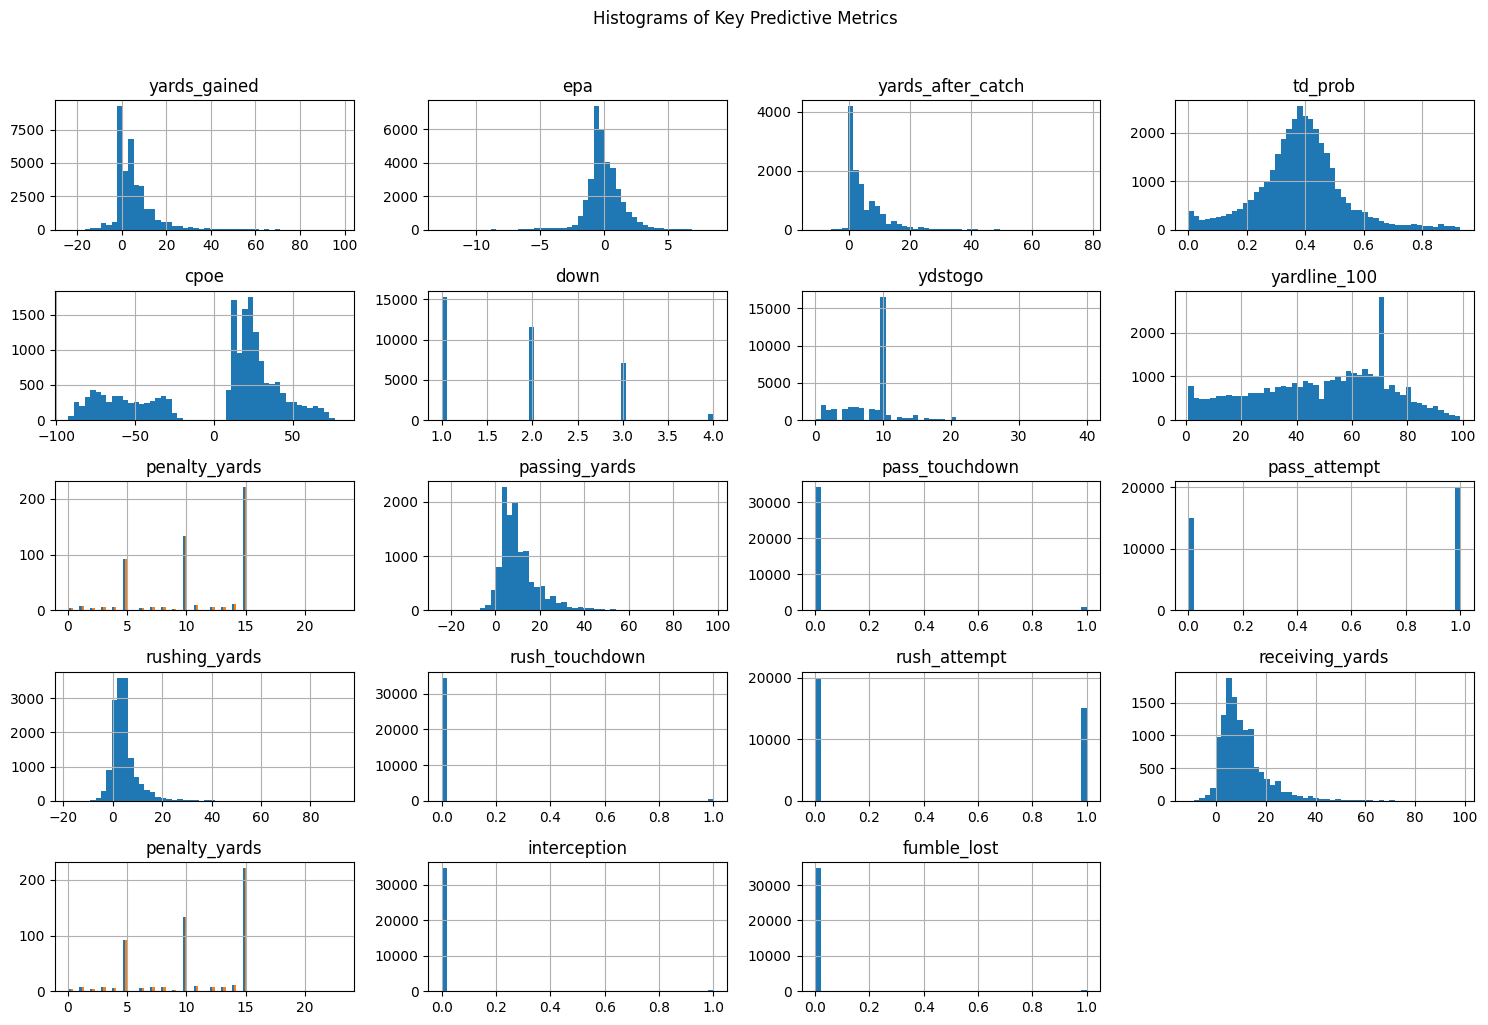

In [42]:
## Numerical Columns ##

# Plot Histograms to visualize the distribution and skewness
df_eda[numerical_cols].hist(figsize=(15, 10), bins=50)
plt.suptitle('Histograms of Key Predictive Metrics', y=1.02)
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

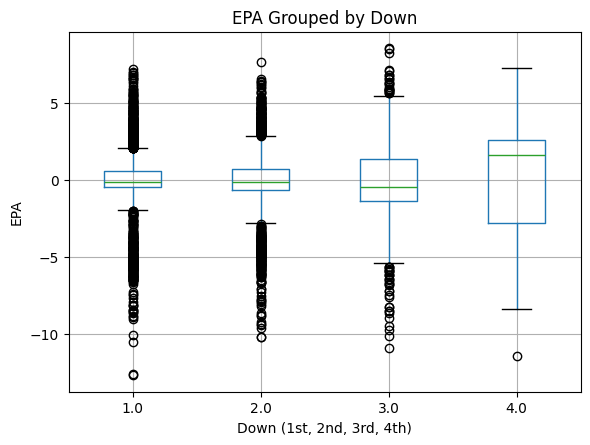

<Figure size 800x600 with 0 Axes>

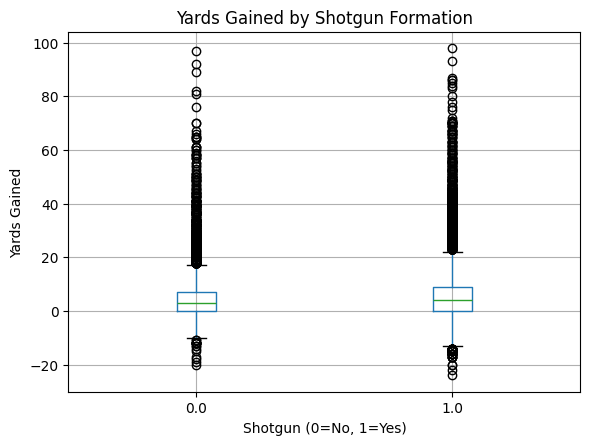

In [43]:
## Grouped distribution plots ##

# Expected Points Added (EPA) by Down
plt.figure(figsize=(8, 6))
df_eda.boxplot(column='epa', by='down', grid=True)
plt.title('EPA Grouped by Down')
plt.suptitle('')
plt.xlabel('Down (1st, 2nd, 3rd, 4th)')
plt.ylabel('EPA')
plt.show()


# Yards gained by Shotgun indicator
plt.figure(figsize=(8, 6))
df_eda.boxplot(column='yards_gained', by='shotgun', grid=True)
plt.title('Yards Gained by Shotgun Formation')
plt.suptitle('')
plt.xlabel('Shotgun (0=No, 1=Yes)')
plt.ylabel('Yards Gained')
plt.show()

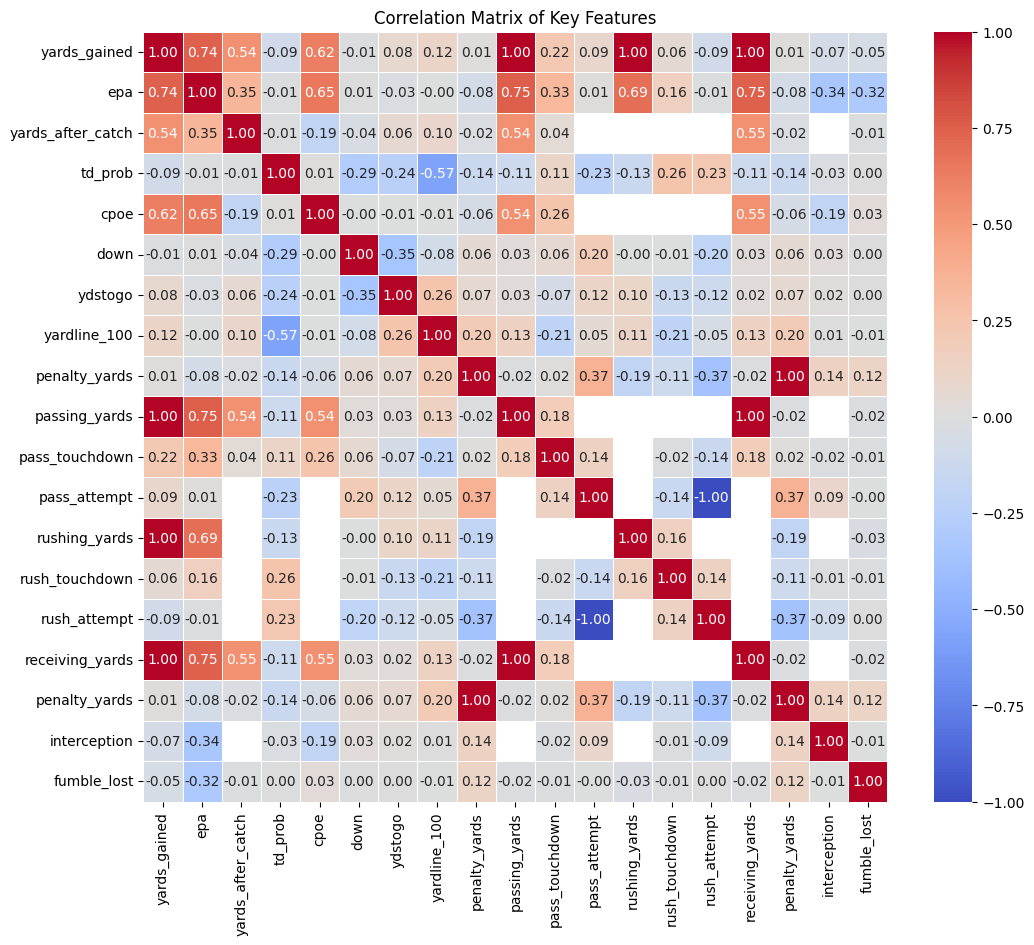

In [44]:
## Correlation Matrix for numerical columns ##

correlation_matrix = df_eda[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Correlation Matrix of Key Features')
plt.show()
#

#### Additional EDA

Below check to see the volatility of passing yards, we want to see separation between quantitles (clear monotonicity), non-constant variances in the quantiles and non-linearity in our mean or what is normally the standard prediction variable.

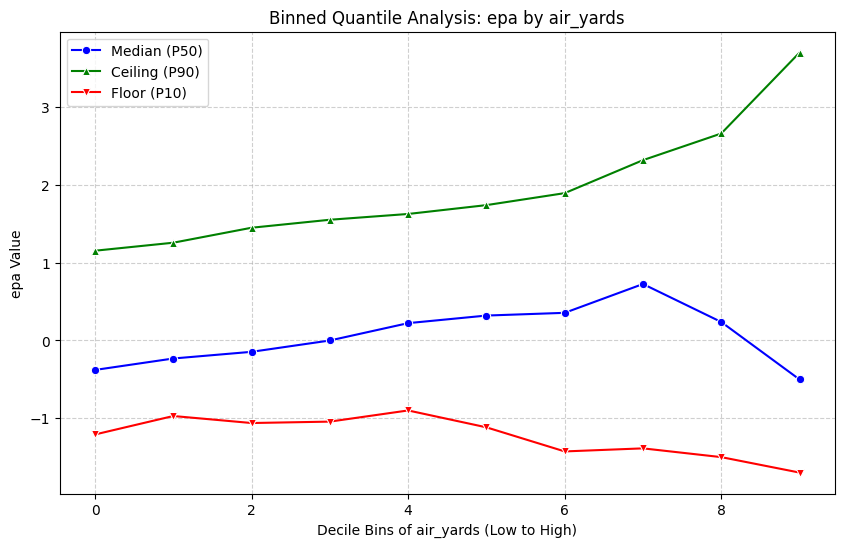

In [ ]:
feature = 'air_yards'
# Outcome variable: EPA (Expected Points Added)
target = 'epa'
num_bins = 10 # For deciles

# Create bins based on the distribution of air_yards
df_eda['air_yards_bin'] = pd.qcut(df_eda[feature], q=num_bins, labels=False, duplicates='drop')

# Quantitles for each bin
quantile_data = df_eda.groupby('air_yards_bin')[target].agg(
    P10=lambda x: x.quantile(0.10),
    P50=lambda x: x.quantile(0.50),
    P90=lambda x: x.quantile(0.90),
    Count='size'
).reset_index()

# Plot quantiles
plt.figure(figsize=(10, 6))
sns.lineplot(x='air_yards_bin', y='P50', data=quantile_data, label='Median (P50)', marker='o', color='blue')
sns.lineplot(x='air_yards_bin', y='P90', data=quantile_data, label='Ceiling (P90)', marker='^', color='green')
sns.lineplot(x='air_yards_bin', y='P10', data=quantile_data, label='Floor (P10)', marker='v', color='red')

plt.title(f'Binned Quantile Analysis: {target} by {feature}')
plt.xlabel(f'Decile Bins of {feature} (Low to High)')
plt.ylabel(f'{target} Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Using valid high-volume receiver ID for ACF test: 00-0036900


<Figure size 1000x500 with 0 Axes>

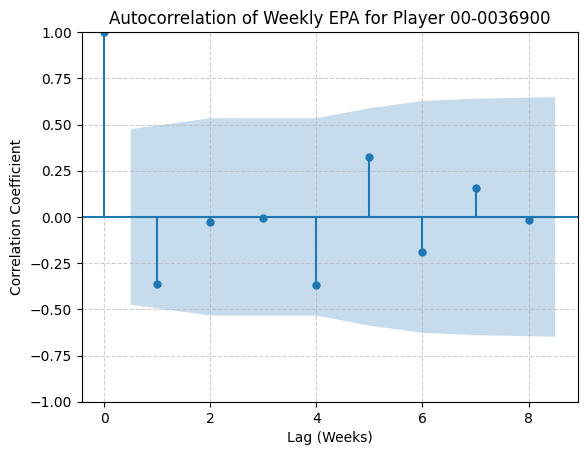

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# --- 1. PRELIMINARY STEP: FIND A VALID, HIGH-VOLUME PLAYER ID ---
# The error was caused by using a placeholder ID that didn't exist in your data.
# We find a legitimate ID with enough volume to create a time series.

try:
    # Get the ID of the receiver with the most plays in your filtered data
    most_common_id = df_eda['receiver_player_id'].value_counts().index[0]
    TEST_PLAYER_ID = most_common_id
    print(f"Using valid high-volume receiver ID for ACF test: {TEST_PLAYER_ID}")
except IndexError:
    print("Error: The 'receiver_player_id' column is empty or contains no valid IDs.")
    TEST_PLAYER_ID = None # Set to None to skip the rest of the code if an ID isn't found

if TEST_PLAYER_ID:
    # --- 2. A. Create a Test Time-Series for the Single Player ---
    
    # Filter the raw data to the single player and aggregate EPA per week
    # .sum() is sufficient here because we are summing EPA for the week
    df_single_player_ts = df_eda[df_eda['receiver_player_id'] == TEST_PLAYER_ID].groupby(
        ['season', 'week']
    )['epa'].sum().reset_index()

    # Ensure the time series is indexed correctly for the ACF plot
    df_single_player_ts.set_index(['season', 'week'], inplace=True)
    
    # Fill missing weeks with 0 EPA (critical for proper time-series analysis)
    # This accounts for bye weeks or weeks the player missed
    idx = pd.MultiIndex.from_product(
        df_single_player_ts.index.levels, 
        names=df_single_player_ts.index.names
    )
    df_single_player_ts = df_single_player_ts.reindex(idx, fill_value=0)
    epa_series = df_single_player_ts['epa']

    # --- 3. B. Plot the Autocorrelation Function (ACF) ---
    plt.figure(figsize=(10, 5))
    
    # The plot_acf function calculates and plots the correlation of the series with its past values
    plot_acf(
        epa_series, 
        lags=8, 
        title=f'Autocorrelation of Weekly EPA for Player {TEST_PLAYER_ID}'
    )
    plt.xlabel('Lag (Weeks)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    #